In [22]:
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

def plot_optimization_results(names, base_path="/home/ubuntu/dev/outputs/optimization-results"):
    """
    Plot optimization results for multiple methods.
    
    Args:
        names: List of folder names under base_path
        base_path: Base directory containing optimization results
    """
    plt.figure(figsize=(10, 6))
    
    for name in names:
        folder_path = Path(base_path) / name
        
        # Find log files in the folder
        log_files = list(folder_path.glob("*.json"))
        
        if not log_files:
            print(f"No log files found in {folder_path}")
            continue
            
        # Use the first log file found
        log_file = log_files[0]
        
        with open(log_file, 'r') as f:
            data = json.load(f)
        
        if 'old_value_pairs_with_i_step' not in data:
            print(f"'old_value_pairs_with_i_step' key not found in {log_file}")
            continue
        
        steps = []
        best_real_values = []
        
        pairs = data['old_value_pairs_with_i_step']
        
        
        # Process each step
        for step in pairs:
            if step == "-1":
                continue
            points = pairs[step]
    
            ranked_points = sorted(points, key=lambda x: (-x[1][0], -x[1][1]))
            best_real_values.append(int(ranked_points[0][2][0] >= 1.0) * ranked_points[0][2][1])
            steps.append(step)
            '''for point in points:
                if len(point) >= 3:
                    params, pred_values, real_values = point[0], point[1], point[2]
                    score = pred_values[2] if len(pred_values) > 2 else float('-inf')
                    
                    if score > best_score:
                        best_score = score
                        best_point = point
            
            if best_point is not None:
                real_value = best_point[2][2] if len(best_point[2]) > 2 else 0
                steps.append(step_num)
                best_real_values.append(real_value)'''
        
        # Plot the line for this method
        if steps and best_real_values:
            plt.plot(steps, best_real_values, marker='o', label=name, linewidth=2, markersize=6)
        else:
            print(f"No valid data points found for {name}")
                
    
    plt.xlabel('Step')
    plt.ylabel('Real Value')
    plt.title('Optimization Progress: Best Real Value per Step')
    plt.legend()
    plt.grid(True, alpha=0.3)
    sns.despine()
    plt.tight_layout()
    plt.show()

# Example usage:
# names = ['openai_eg_max', 'openai_eg_few', 'another_method']
# plot_optimization_results(names)

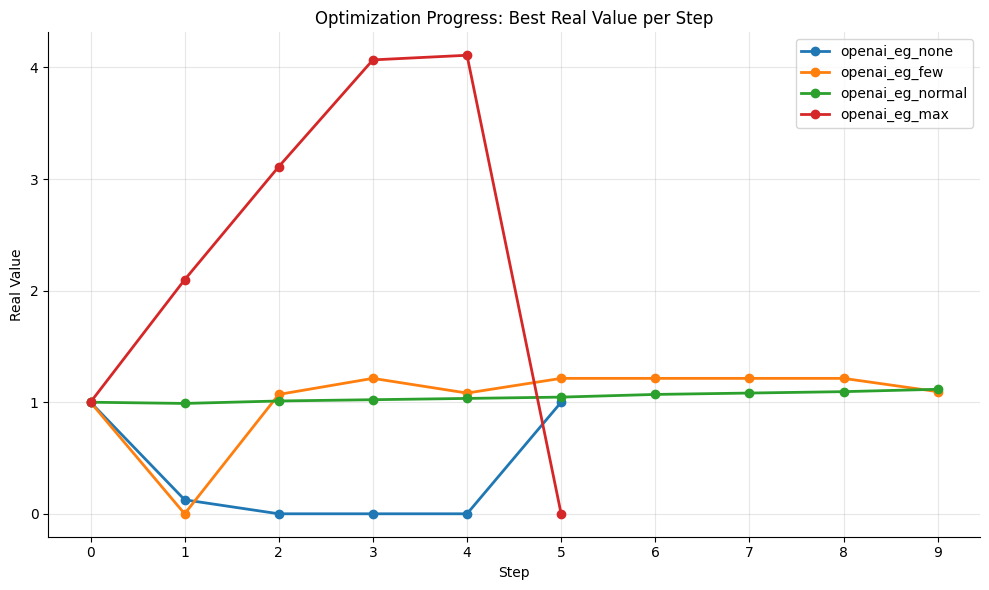

In [23]:
names = ['openai_eg_none', 'openai_eg_few', 'openai_eg_normal', 'openai_eg_max']
plot_optimization_results(names)